### Contents
1. [Project Description](#project)
    * [Data ](#data_provided)
2. [Exploratory Data Analysis](#eda)
    * [Distribution of Categories](#distribution)
    * [Length of audio utterances](#audio_files)
    * [Checking the voices](#voices)
    * [Spectrogram of the voices](#spectrum)
    * [Checking the noises](#noises)  
    * [Spectrogram of the noises](#noises_spectrum)
3. [Mel-scaled log filter-bank](#mslfb)
    * [Why MS-LFB](#why_mslfb)
    * [Spectrogram of a signal](#spectrum_fft)
    * [MS-LFB frequency filter banks](#mslfb_banks)
    * [MS-LFB architecture](#mslfb_architecture)
    * [MS-LFB CNN model](#mslfb_cnn)
    * [Implementing MS-LFB](#mslfb_implmentation)
    * [MS-LFB CNN model performance](#mslfb_performance)
    * [Measuring accuracy on commands](#balanced_accuracy)
4. [MFCC (Mel Frequency Cepstral Coefficients)](#mfcc)
    * [Difference between MFCC and MS-LFB](#mfcc_mslfb)
    * [Generating MFCC using Librosa](#librosa_mfcc)
    * [Implementation of MFCC](#implementation_mfcc)
    * [MFCC CNN model performance](#mfcc_performance)
5. [Ensemble Model](#ensemble_model)
    * [Combining the models](#combining)
    * [Full implementation of the ensemble model](#ensemble_implementation)
6. [Results and Conclusion](#conclusion)
7. [References](#refrences)


<a id="project"></a>
## <center>1. Project Description</center>

This is a project to detect the 10 following 1 second voice commands sampled at 16kHz :

yes, no, up, down, left, right, on, off, stop, go

The code also recognizes if there is silence or if the word is not recognized.

<a id="data_provided"></a>
### Data 
The training data is provided by the Google Brain challenge named: TensorFlow Speech Recognition Challenge and contains about 23k samples of the 10 voice commands mentioned above and a total of 64721 utterances in total. In addition to the command voices, there are 20 other word utterances to be used as sample other words that might be mentioned and need to be categorized as unknown words. All the data has been divided to 70% for training and 30% to validation in this work. 

The data is gathered by thousands of volunteers across the world. 

Also, there have been sample noises provided which were randomly selected and added to the train and validation sets to make the train and validation more real world like scenarios. 


<a id="eda"></a>
## <center>2. Exploratory Data Analysis</center>

<a id="distribution"></a>
### Distribution of Categories

Here is how many times each utterance is present in the data. using the following code:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os

!apt-get install -y p7zip-full
!7z x ../input/tensorflow-speech-recognition-challenge/train.7z

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.io import wavfile
train_directory = 'train/audio/'
train_labels = []
train_samples = []
# Loading all the waves and labels
for trains in os.listdir(train_directory):
    if trains == '_background_noise_':
        continue
    for wav_file in os.listdir(os.path.join(train_directory, trains)):
        if wav_file[-4:] != '.wav':
            continue
        sample_rate, sample = wavfile.read(os.path.join(os.path.join(train_directory, trains), wav_file))
        train_labels.append(trains)
        train_samples.append((sample))
        
train_pd = pd.DataFrame({'label':train_labels})
fig, axis = plt.subplots(figsize=(20, 8))
sns.countplot(ax=axis, x="label", data=train_pd)
print(train_pd.label.unique())
plt.show()

<a id="audio_files"></a>
### Length of the Audio Utterances
Not all utterances in the data have the full length of 16k samples. Overall 6469 utterances don't have the full length which would be padded with zeros later on. There are also 58252 full length utterances available. Here is the distribution of the length of the utterances:

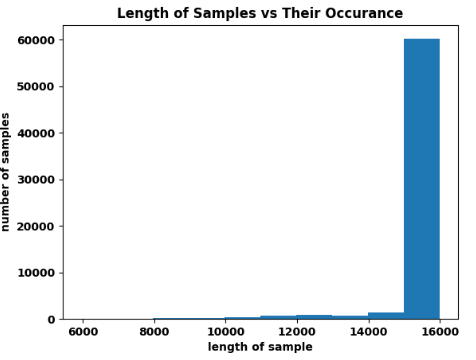

<a id="voices"></a>
### Checking the Voices

Here is how a sample utterance sound like when played using the following code: 

In [ ]:
import IPython.display as ipd
ipd.Audio(train_directory + r'/bed/00f0204f_nohash_0.wav', rate=16000)






Looking at the utterances here is how a few randomly selected ones look like in time domain with the word mentioned above each plot:

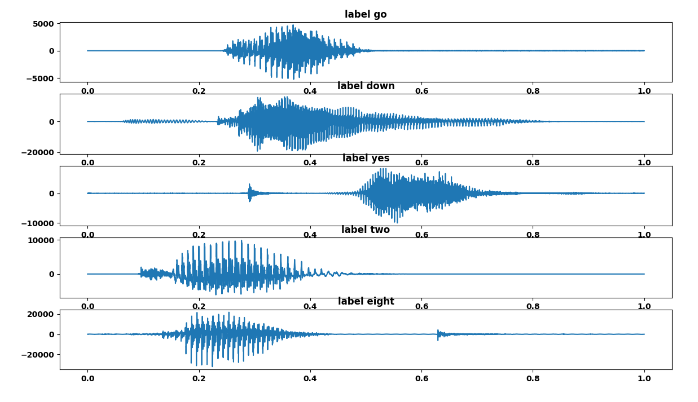

Of course this is before any noises is added to the samples. Also, the utterances are normally not taking the full 1 second so they could possibly be trimmed based on the energy of the signal. Here however, they have not been trimmed in case when the model is tested latter the utterance would take longer or their energy could not be clearly distinguished from the noise.

<a id="spectrum"></a>
### Spectrogram of the Voices

Here is how the Bed utterance looks like after a 512 point FFT operation on windowed signal and applying a Hanning window with size 20 and overlap of 10 samples which would be explained more later. 

In [ ]:
from scipy import signal
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate,window='hann',nperseg=nperseg,noverlap=noverlap,detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

freqs, times, spectrogram = log_specgram(train_samples[0], sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of Bed utterance')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(train_samples[0]), sample_rate), train_samples[0])
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of Bed utterance')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

<a id="noises"></a>
### Checking the Noises

There are 6 noise files with a total of ~400 Seconds provided. 1 second long portions of the noises have been randomly selected and added to the raw utterances so that they would be closer to real world scenarios. 

<a id="noises_spectrum"></a>
### Spectrogram of the Noises

Here is the waveform and spectrum of a sample noise file using the same 512 point FFT and Hanning window with size 20 and overlap of 10 samples

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os

noise_directory = 'train/audio/_background_noise_'
noise_samples = []
for noises in os.listdir(noise_directory):
    if noises[-4:] != '.wav':
        continue
    noise_sample_rate, noise_sample = wavfile.read(os.path.join(noise_directory, noises))
    #noise_resampled = librosa.resample(noise_sample.astype(np.float), orig_sr=noise_sample_rate, target_sr=sample_rate)
    noise_resampled = noise_sample
    noise_samples.append(noise_resampled)


def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

freqs, times, spectrogram = log_specgram(noise_samples[0], sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of Sample Noise')
ax1.set_ylabel('Amplitude')
x = np.linspace(0, len(noise_samples[0])/ sample_rate, len(noise_samples[0]))
ax1.plot(x, noise_samples[0])
ax1.set_xticks(np.arange(0, len(x)/ sample_rate , 10))
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::1000])
ax2.set_title('Spectrogram of Sample Noise')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')
plt.show()


<a id="mslfb"></a>
## <center>3. Mel-scaled log filter-bank</center>

<a id="why_mslfb"></a>
### Why MS-LFB

Based on the book  “Automatic Speech Recognition: A Deep Learning Approach.” at reference [1], the most used raw features for speech recognition are Mel Frequency Cepstral Coefficients (MFCC) and Perceptual Linear Predictive (PLP) which both are derived from Mel-Scaled Log Filter-Bank features (MS-LFB). Experiments by this book are showing that MS-LFB can outperform MFCC when tested on a full multiple word speech with a relative Word Error Rate (WER) improvement of 4.4% . So MS-LFB is considered as a good candidate to be used as a feature for this work. 

<a id="spectrum_fft"></a>
### Spectrogram of a Signal

To calculate the MS-LFB of a signal we first need to calculate its spectrum. Since frequency content of voices are changing over time and they are not periodic signals with the fixed frequency content, their Discrete Fourier Transform (DFT) can not be calculated directly on the entire signal. So a work around is to consider only a small portion (window of tens of ms) of the voice as stationary with fixed frequencies. i.e we can find the frequency content of each small window and show the frequency content as they are changing over these small windows. One issue with this approach is the edges of these selected windows which will have sharp edges and introduce unwanted high frequency content. To alleviate this problem a filter can be multiplied to each window to reduce the value of the edges of the signal in each window. Lastly, to make sure that there is not lost data in between windows, a portion of the selected windows are overlapped. A good representation of this process can be found in reference [2] and it is shown here: 

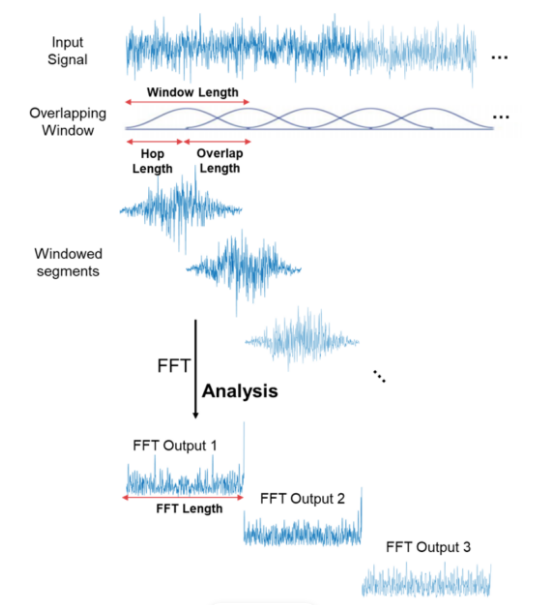

<a id="mslfb_banks"></a>
### MS-LFB Frequency Filter Banks

The idea of Mel-Scaling is that the human ear can hear different frequency resolutions at different frequencies. In other words, we are more sensitive to the lower range of our hearing range as compared to its higher frequencies. So a scaling method is developed to change the frequencies to Mel_Scale which is based on having the same human ear resolution at all scales. The formula used to convert the frequency in Hz to Mel-Scale are the following: 

m = 2959 * log10 ( 1 + freq / 700) 

Here is a representation of this scaling which shows the conversion between frequency and Mel Scale for an utterance that has upto 8KHz frequency content. 

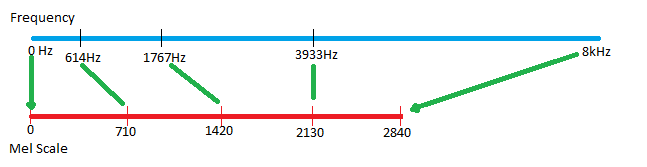

To find the MS-LFB, a set of filters have been developed that are multiplied with the squared magnitude of the FFT results of each window of the signal. These filters add the frequency energy of the signal at each Mel_Scaled bin and only present the signal at each window with the values at these bins of frequency energy. A full signal would therefore be represented by the number of these filters times the number of windows for the length of the signal. 
Here is a set of 40 filters used for a signal that has been sampled at 16Khz and has frequency content up to 8kHz. 

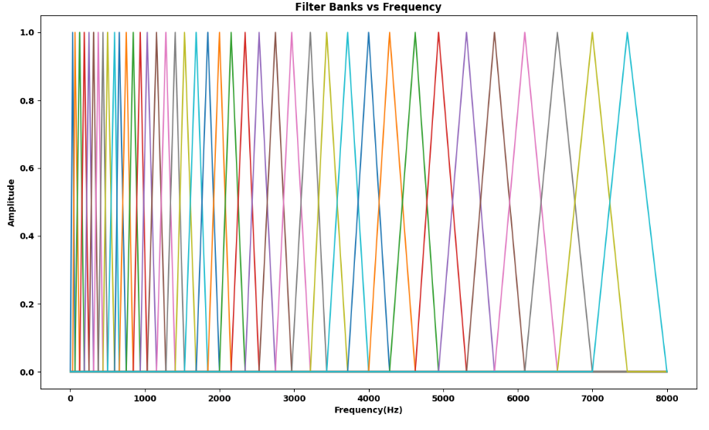

<a id="mslfb_architecture"></a>
### MS-LFB Architecture

The overall architecture of the MS_LFB is what described above with the addition of a pre-emphasis state at the beginning to reduce the noise effect by subtracting a portion of the previous value of the signal from future one and a log operation at the end. 

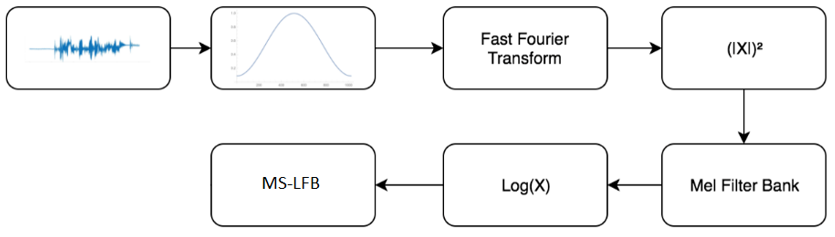

<a id="mslfb_cnn"></a>
### MS-LFB CNN Model

A CNN model has been constructed based on the MS-LFB coefficients and using the 2D output of MS-LFB over time similar to a grayscale image. The image is fed into multiple layers of 2D convolution combined with pooling and dropout layers. Finally the layers have been flattened and with multiple dense layers predicted the output. The full model code is included in the ensemble model so it is not repeated here. But here is an image from reference [8] which describes this process: 

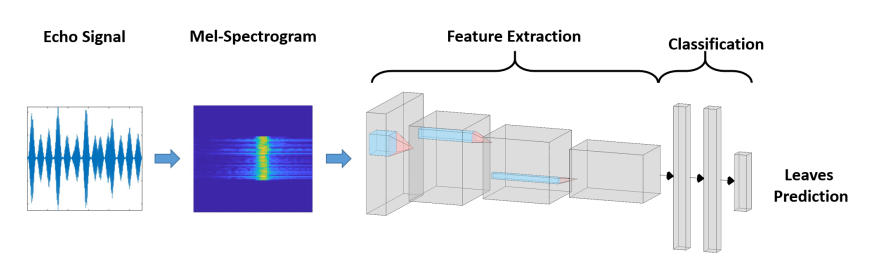

<a id="mslfb_implmentation"></a>
### Implementing MS-LFB

Here is an implementation of the MS-LFB based on the reference [4]


In [ ]:
def MSLFB(signal_resampled):
    pre_emphasis = 0.97
    frame_size = 0.025
    frame_stride = 0.01
    NFFT = 512  # FFT Size
    nfilt = 40  # number of filters
    emphasized_signal = np.append(signal_resampled[0], signal_resampled[1:] - pre_emphasis * signal_resampled[:-1])
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)  # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    frames *= np.hamming(frame_length)
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10 ** (mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])  # left
        f_m = int(bin[m])  # center
        f_m_plus = int(bin[m + 1])  # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks_eps = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks_log = 20 * np.log10(filter_banks_eps)  # dB
    filter_banks_log -= (np.mean(filter_banks_log, axis=0) + 1e-8)
    return abs(filter_banks_log)

<a id="mslfb_performance"></a>
### MS-LFB CNN model performance

A CNN model based on MS-LFB has been set up and trained as an independent model. Here is the accuracy and loss vs the epoch. The code is included in the ensemble model provided later on in the document so it is not repeated here. 

Training and validation accuracy and loss are shown below. The validation accuracy is reaching close to 91.51% over batches of 256 utterances.

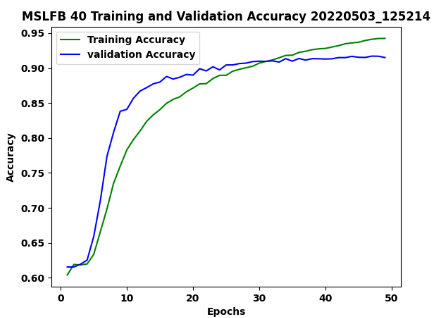

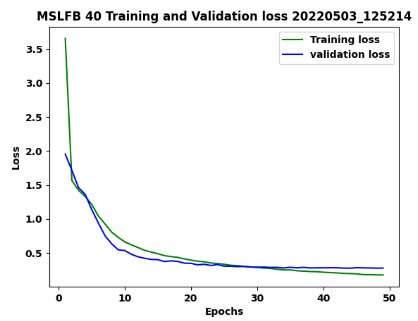

<a id="balanced_accuracy"></a>
### Measuring Accuracy on Commands

Because a large portion of the samples are considered as 'unknown' words which are additional words to make sure not every command would be considered as one of the 10 commands, the database is an unbalanced dataset. To address this issue a separate code tests the performance when the non-command words and silence are excluded. In this case a validation accuracy of 83.06% has been measured over 10k randomly selected validation cases but with dropping the cases that are either a non-command or a silence. The code for this calculation is included in the ensemble implementation and has not been repeated here. 

<a id="mfcc"></a>
## <center>4. MFCC (Mel Frequency Cepstral Coefficients)</center>

<a id="mfcc_mslfb"></a>
### Difference Between MFCC and MS-LFB

MFCC is based on MS-LFB with an addition of a Discrete Cosine Transform (DCT) operation at the end to get the spectrum of the MS-LFB coefficients. This is because there are some correlation in between the MS-LFB values and by applying the DCT and keeping only first 12  coefficients (called cepstral coefficients) we will have a compressed representation of the signal. 

<a id="librosa_mfcc"></a>
### Generating MFCC Using Librosa

The MFCC can be implemented in python with the Librosa library with the following one line command. 



In [ ]:
mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12)

<a id="implementation_mfcc"></a>
### Implementation of MFCC

Here, since the MS-LFB has been implemented, the MFCC was derived with a small additional function

In [ ]:
def MFCC(signal_resampled):
    num_ceps = 12
    filter_banks = MSLFB(signal_resampled)
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1: (num_ceps + 1)] 
    return mfcc

<a id="mfcc_performance"></a>
### MFCC CNN Model Performance

The MFCC model has also been implemented as a separate CNN model. The model is included in the ensemble code so it is not repeated here. Here is the performance of the MFCC with 12 coefficients. The validation accuracy here reaches 89.8% on the 256 batch size testing and 79.8% when the non-command words have been excluded (balanced data) on 10k randomly selected utterances similar to the MS-LFB case. Even though the performance was slightly lower, the training speed was significantly higher due to the smaller number of coefficients use. 

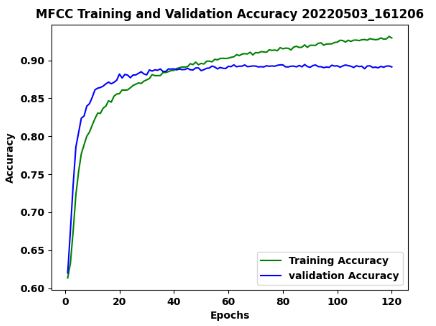

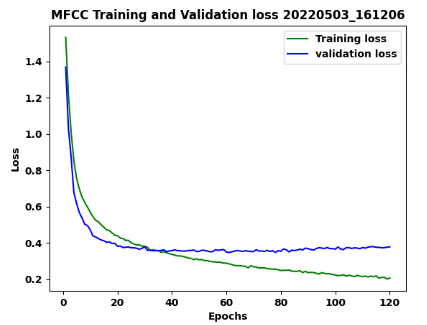

<a id="ensemble_model"></a>
## <center>5. Ensemble Model</center>

<a id="combining"></a>
### Combining the Models

To improve the accuracy of the predictions, an ensemble of the two models mentioned above has been used. There are 3 methods to combine the models and create an ensemble which are explained with details in reference [1]. 

Here is a short description of the three methods: 
1. The features obtained from the utterances can be combined together and fed into a model, 
2. There could be two models using the features separately and a final portion of the model could combine the results 
3. Each model could make its own decision and the results could be looked at with a voting mechanism. 

Here the 2nd method has been used where a portion of the models are shared and a final layer will make the last call on what should be predicted. Below is an illustration of this method: 

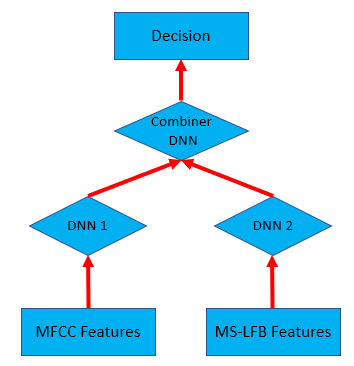

<a id="ensemble_implementation"></a>
### Full Implementation of the Ensemble Model

Below is the full implementation of the ensemble model. The key here is the combining of the model's outputs with an additional layers at the end which is implemented with concatinating the tensors of output of each model and running a last layer on the result. Also, the weights have been loaded from the training of each individual model when trained independently but they have not been frozen so that they can still be trained. 

Lastly, the code has been run on a PyCharm environment and the directory references are for the local machine. 


In [ ]:
import numpy as np
from scipy.io import wavfile
import os
from sklearn.preprocessing import LabelEncoder
import keras
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import keras.regularizers
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import LearningRateScheduler
from datetime import datetime
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
from scipy.fftpack import dct
import seaborn as sns
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model

def MSLFB(signal_resampled):
    pre_emphasis = 0.97
    frame_size = 0.025
    frame_stride = 0.01
    NFFT = 512  # FFT Size
    nfilt = 40  # number of filters
    emphasized_signal = np.append(signal_resampled[0], signal_resampled[1:] - pre_emphasis * signal_resampled[:-1])
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)  # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    frames *= np.hamming(frame_length)
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10 ** (mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])  # left
        f_m = int(bin[m])  # center
        f_m_plus = int(bin[m + 1])  # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks_eps = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks_log = 20 * np.log10(filter_banks_eps)  # dB
    filter_banks_log -= (np.mean(filter_banks_log, axis=0) + 1e-8)
    return abs(filter_banks_log)


def MFCC(signal_resampled):
    num_ceps = 12
    filter_banks = MSLFB(signal_resampled)
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1: (num_ceps + 1)]  # Keep 2-13
    #mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=4)
    return mfcc


def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''

    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch / step_size))

    return LearningRateScheduler(schedule)


# Defining directories
train_directory = r'C:\Users\arasp\Documents\AI\Kaggle\word_detection\train\audio'
test_directory = r'C:\Users\arasp\Documents\AI\Kaggle\word_detection\test\audio'
main_directory = r'C:\Users\arasp\Documents\AI\Kaggle\word_detection'
noise_directory = r'C:\Users\arasp\Documents\AI\Kaggle\word_detection\train\audio\_background_noise_'

noise_coef = 0.1
silence_coef = 0.1
drop_out_rate = 0.5
num_epochs = 120
num_silences = 1700
audio_length = 16000
sample_rate = 16000
classes = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'silence', 'stop', 'unknown', 'up', 'yes']
ipd.Audio(train_directory + r'\bed\00f0204f_nohash_0.wav')

# To hold waves as xs and labels as y of training
train_samples = []
train_labels = []
noise_samples = []
for noises in os.listdir(noise_directory):
    if noises[-4:] != '.wav':
        continue
    noise_sample_rate, noise_sample = wavfile.read(os.path.join(noise_directory, noises))
    #noise_resampled = librosa.resample(noise_sample.astype(np.float), orig_sr=noise_sample_rate, target_sr=sample_rate)
    noise_resampled = noise_sample
    noise_samples.append(noise_resampled)

# Loading all the waves and labels
for trains in os.listdir(train_directory):
    if trains == '_background_noise_':
        continue
    for wav_file in os.listdir(os.path.join(train_directory, trains)):
        if wav_file[-4:] != '.wav':
            continue
        sample_rate_init, sample = wavfile.read(os.path.join(os.path.join(train_directory, trains), wav_file))
        signal_resampled = sample
        #signal_resampled = librosa.resample(sample.astype(np.float), orig_sr=sample_rate_init, target_sr=sample_rate)
        if len(signal_resampled) != audio_length:
            zeros_needed = audio_length - len(signal_resampled)
            signal_resampled = np.append(signal_resampled, np.zeros((zeros_needed))) # if the length is not right just pad with zeros
        #adding noise to the samples
        nois_type_indx = np.random.randint(0, len(noise_samples), 1)
        nois_sample_indx = np.random.randint(0, len(noise_samples[int(nois_type_indx)]) - audio_length, 1)
        sample_noise = signal_resampled + noise_coef * noise_samples[int(nois_type_indx)][int(nois_sample_indx):int(nois_sample_indx) + audio_length]
        train_samples.append(sample_noise)
        if trains not in ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']:
            train_labels.append('unknown')
        else:
            train_labels.append(trains)

# adding portions of weakened background noise as silence
for num_sil in range(num_silences):
    silence_type_indx = np.random.randint(0, len(noise_samples), 1)
    silence_sample_indx = np.random.randint(0, len(noise_samples[int(silence_type_indx)]) - audio_length, 1)
    sample_silence = silence_coef * noise_samples[int(silence_type_indx)][int(silence_sample_indx):int(silence_sample_indx) + audio_length]
    train_labels.append('silence')
    train_samples.append(sample_silence)

# converting labels from text to int
le = LabelEncoder()
y_all = le.fit_transform(train_labels)
y_all_hot = keras.utils.np_utils.to_categorical(y_all, len(le.classes_))
# To make sure all arrays are having a defined size
x_train, x_test, y_train_one_hot, y_test_one_hot = train_test_split(train_samples, y_all_hot, test_size=0.3, random_state=42)

x_train_mslfb = []
x_train_mfcc = []
for ind in range(len(x_train)):
    x_train_mslfb.append(MSLFB(x_train[ind]))
    x_train_mfcc.append(MFCC(x_train[ind]))

x_test_mslfb = []
x_test_mfcc = []
for ind in range(len(x_test)):
    x_test_mslfb.append(MSLFB(x_test[ind]))
    x_test_mfcc.append(MFCC(x_test[ind]))

x_train_mslfb_reshaped = np.reshape(x_train_mslfb, (len(x_train_mslfb), len(x_train_mslfb[0]), len(x_train_mslfb[0][0]), 1))
x_test_mslfb_reshaped = np.reshape(x_test_mslfb, (len(x_test_mslfb), len(x_test_mslfb[0]), len(x_test_mslfb[0][0]), 1))
x_train_mfcc_reshaped = np.reshape(x_train_mfcc, (len(x_train_mfcc), len(x_train_mfcc[0]), len(x_train_mfcc[0][0]), 1))
x_test_mfcc_reshaped = np.reshape(x_test_mfcc, (len(x_test_mfcc), len(x_test_mfcc[0]), len(x_test_mfcc[0][0]), 1))

#Creatigng the model

input_shape_mfcc = (98, 12, 1)
input_shape_mslfb = (98, 40, 1)
mfcc_input = Input(input_shape_mfcc)
mslfb_input = Input(input_shape_mslfb)

model_mfcc = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=16, kernel_size=(4, 4), padding='valid', activation='relu', input_shape=(x_train_mfcc_reshaped.shape[1], x_train_mfcc_reshaped.shape[2], 1)), #, kernel_regularizer=keras.regularizers.l2(0.0001)
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(4, 4), padding='valid', activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(2, 2), padding='same', activation='relu'),
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256,  activation='relu'),
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Dense(128,  activation='relu'),
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Dense(12, activation='relu')
])

model_mslfb = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=16, kernel_size=(4, 4), padding='valid', activation='relu', input_shape=(x_train_mslfb_reshaped.shape[1], x_train_mslfb_reshaped.shape[2], 1)), #, kernel_regularizer=keras.regularizers.l2(0.0001)
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(4, 4), padding='valid', activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(2, 2), padding='same', activation='relu'),
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256,  activation='relu'),
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Dense(128,  activation='relu'),
  tf.keras.layers.Dropout(drop_out_rate),
  tf.keras.layers.Dense(12, activation='relu')
])

model_mslfb.load_weights(r'C:\Users\arasp\Documents\AI\Kaggle\word_detection\model\conv2d_MSLFB20220503_125214lr_1em3.h5')
model_mfcc.load_weights(r'C:\Users\arasp\Documents\AI\Kaggle\word_detection\model\conv2d_MFCC20220503_161206lr_1em3.h5')


encoded_mfcc = model_mfcc(mfcc_input)
encoded_mslfb = model_mslfb(mslfb_input)
concatinated = tf.concat([encoded_mfcc, encoded_mslfb], 1)
prediction = Dense(12, activation='softmax')(concatinated)
ensemble_model = Model(inputs=[mfcc_input, mslfb_input], outputs=prediction)

file_date = datetime.now().strftime("%Y%m%d_%H%M%S")
# Call back Definitions
lr_sched = step_decay_schedule(initial_lr=0.001, decay_factor=0.97, step_size=5)
cb_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.003, patience=30, mode='max')
csv_logger = tf.keras.callbacks.CSVLogger(r'C:\Users\arasp\Documents\AI\coding\model\csv_logger_' + file_date + '.tb', separator=",", append=False)
# Compile and fitting the model
optimizer = Adam(learning_rate=0.001)
ensemble_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = ensemble_model.fit([x_train_mfcc_reshaped, x_train_mslfb_reshaped], y_train_one_hot, batch_size=256, epochs=num_epochs, callbacks=[lr_sched, cb_earlystop], validation_data=([x_test_mfcc_reshaped, x_test_mslfb_reshaped], y_test_one_hot), verbose=1)
ensemble_model.save(        r'C:\Users\arasp\Documents\AI\Kaggle\word_detection\model\ensemble_mfcc_mslfb' + file_date + 'lr_1em3.h5')

ensemble_model.summary()
# Plotting the loss vs epoch
loss_train = history.history['loss'][0:]
loss_val = history.history['val_loss'][0:]
epochs = range(1, len(history.epoch) + 1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Ensemble MSLFB and MFCC loss ' + file_date)# Training and Validation
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy vs epoch
train_accuracy = history.history['accuracy'][0:]
val_accuracy = history.history['val_accuracy'][0:]
epochs = range(1, len(history.epoch) + 1)
plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='validation Accuracy')
plt.title('Ensemble MSLFB and MFCC Accuracy ' + file_date)#Training and Validation
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

correct_pred = 0
inc_pred = 0
for val_ind in range(10000):
    rand_ind = np.random.randint(0, len(x_test), 1)
    if np.argmax(y_test_one_hot[rand_ind]) == 9 or np.argmax(y_test_one_hot[rand_ind]) == 7:
        continue
    prediction = ensemble_model.predict([x_test_mfcc_reshaped[rand_ind], x_test_mslfb_reshaped[rand_ind]])
    if np.argmax(prediction) == np.argmax(y_test_one_hot[rand_ind]):
        correct_pred += 1
    else:
        inc_pred += 1
print('Percent correct of known words', correct_pred / (correct_pred + inc_pred) * 100)


result_directory = os.path.join(main_directory, 'results')
outfile = open(os.path.join(result_directory, 'predictions_Aras_Pirbadian_ensemble.csv'), 'w')
for test_file in os.listdir(test_directory):
    if test_file[-4:] != '.wav':
        continue
    sample_rate, sample = wavfile.read(os.path.join(test_directory, test_file))
    if len(sample) != audio_length:
        zeros_needed = audio_length - len(sample)
        sample = np.append(sample, np.zeros((zeros_needed)))
    MSLFB_sample = MFCC(sample)
    sample_reshaped = np.reshape(MSLFB_sample, (1, MSLFB_sample.shape[0], MSLFB_sample.shape[1], 1))
    prediction = ensemble_model.predict(sample_reshaped)
    onerow = '{},{}'.format(str(test_file), classes[int(np.argmax(prediction))]) + '\n'
    outfile.write(onerow)
outfile.close()


<a id="conclusion"></a>
## <center>6. Results and Conclusion</center>

Overall, MS-LFB with the size of 40 coefficients performs about 3.2% better on the command utterances and 1.7% when considering all utterances. The ensemble model performs 1.5% better than MS-LFB on command utterances and and about the same as MS-LFB when considering all utterances. This is likely because the MFCC here is using less coefficients and has been derived from the MS-LFB so despite its much faster training speed, its improvements to the ensemble model is limited. Here is a table summarizing these findings: 

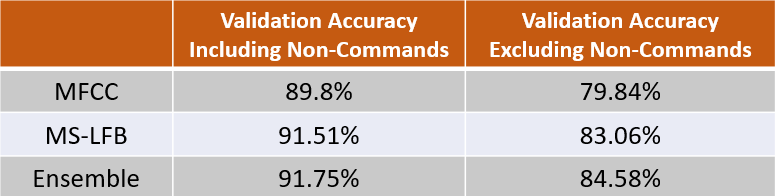


<a id="refrences"></a>
## <center>7. References</center>

[1] Yu, Dong and Li Deng. “Automatic Speech Recognition: A Deep Learning Approach.” (2014).

[2] https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

[3] https://medium.com/linagoralabs/computing-mfccs-voice-recognition-features-on-arm-systems-dae45f016eb6

[4] https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

[5] Uday Kamath, John Liu, James Whitaker. "Deep Learning for NLP and Speech Recognition" (2019)

[6] Jiang, Wenbin et al. “Speech Magnitude Spectrum Reconstruction from MFCCs Using Deep Neural Network.” Chinese Journal of Electronics 27 (2018): 393-398.

[7] Dahl, George E. et al. “Context-Dependent Pre-Trained Deep Neural Networks for Large-Vocabulary Speech Recognition.” IEEE Transactions on Audio, Speech, and Language Processing 20 (2012): 30-42.

[8] Tanveer, Muhammad Hassan et al. “Mel-spectrogram and Deep CNN Based Representation Learning from Bio-Sonar Implementation on UAVs.” 2021 International Conference on Computer, Control and Robotics (ICCCR) (2021): 220-224.

[9] Hönig, Florian et al. “Revising Perceptual Linear Prediction (PLP).” INTERSPEECH (2005).